In [435]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors,tree
import random
random.seed(7)

### Clean up the data again for Task3

In [436]:
#CleanUp the dataset for task3
mydata = pd.read_csv("./USA_coviddata_clean_50.csv")
#delete useless feature
mydata = mydata.drop(labels=['Unnamed: 0','sub_region_1','hospitalized_cumulative'],axis=1)

#delete the rows that do not have labels
mydata =mydata[mydata['hospitalized_new'].notna()]

#--------------fill the missing data to the average of its column-----------#
# for colname,col in mydata.iteritems():
#     if 'symptom' in colname:
#         symptom_mean = round(mydata[colname].mean(),2)
#         mydata[colname].fillna(symptom_mean,inplace=True)
mydata.fillna(0,inplace=True)
# --------------fill the missing data to the average of its column-----------#

### find the 11 states that we are using

In [437]:
regionlist = mydata['open_covid_region_code'].unique()
random.shuffle(regionlist)
print(regionlist)

['US-ID' 'US-WY' 'US-MT' 'US-SD' 'US-RI' 'US-ND' 'US-NM' 'US-HI' 'US-NH'
 'US-ME' 'US-NE']


### Define the function that split the set based on region

In [438]:
def split_set(dataset,state_name1, state_name2):
    validate_set = dataset.loc[
        (dataset['open_covid_region_code'] == state_name1) | (dataset['open_covid_region_code'] == state_name2)]
    training_set = dataset.loc[
        (dataset['open_covid_region_code'] != state_name1) & (dataset['open_covid_region_code'] != state_name2)]

    # delete the region and date features
    validate_set = validate_set.drop(labels=['date', 'open_covid_region_code'], axis=1)
    training_set = training_set.drop(labels=['date', 'open_covid_region_code'], axis=1)
    # #convert pandas to numpy
    training_set =training_set.values
    validate_set = validate_set.values
    
    # split the data into features and label
    x_train, y_train = np.delete(training_set, [0], axis=1).astype(np.float), training_set[:, 0].astype(np.float)
    x_validate, y_validate = np.delete(validate_set, [0], axis=1).astype(np.float), validate_set[:, 0].astype(
        np.float)
    return x_train,y_train,x_validate,y_validate

###  Define the function tha train the data, do the prediction, and calculate the MSE

In [439]:
def domodel(x_train,y_train,x_validate,y_validate,modelname):
    #define the MSE functioon
    loss = lambda y, yh: np.mean((y - yh) ** 2)
    K_list = range(1, 100)
    err_train, err_valid =[], []
    for i, K in enumerate(K_list):
        if modelname == 'knn':
            model = neighbors.KNeighborsRegressor(n_neighbors=K)
        else:
            model = tree.DecisionTreeRegressor(min_samples_leaf=K)
        model = model.fit(x_train, y_train)
        err_valid.append(loss(model.predict(x_validate),y_validate))
        err_train.append(loss(model.predict(x_train),y_train))
    return err_valid

### Do 5 times validation based on 5 different validation sets and training sets

In [440]:
K_list = range(1, 100)
num_folds = 5
#use it to store 5 validation error sets
errorvalid_knn = np.zeros((len(K_list), num_folds)) 
errorvalid_dt = np.zeros((len(K_list), num_folds)) 

#do cross validation 5 times
for i in range(0,len(regionlist)-1,2):
    print("validation set",i//2,":",regionlist[i],regionlist[i+1])
    
    #use 2 states as validation set and 9 states as training set
    x_train,y_train,x_validate,y_validate=split_set(mydata,regionlist[i],regionlist[i+1])
    
    print("#data in validation set",i//2,":",x_validate.shape[0])
    print("#data in training set",i//2,":",x_train.shape[0],'\n')
    #apply the data into knn model
    this_errorvalid_knn = domodel(x_train,y_train,x_validate,y_validate,'knn')
    errorvalid_knn[:,i//2] = this_errorvalid_knn
    #apply the data into decisionTree model
    this_errorvalid_dt = domodel(x_train,y_train,x_validate,y_validate,'dt')
    errorvalid_dt[:,i//2] = this_errorvalid_dt
    

validation set 0 : US-ID US-WY
#data in validation set 0 : 52
#data in training set 0 : 221 

validation set 1 : US-MT US-SD
#data in validation set 1 : 51
#data in training set 1 : 222 

validation set 2 : US-RI US-ND
#data in validation set 2 : 53
#data in training set 2 : 220 

validation set 3 : US-NM US-HI
#data in validation set 3 : 49
#data in training set 3 : 224 

validation set 4 : US-NH US-ME
#data in validation set 4 : 52
#data in training set 4 : 221 



BEST K for REGION split: 76
Best MSE for REGION split: 3760.1094996007473


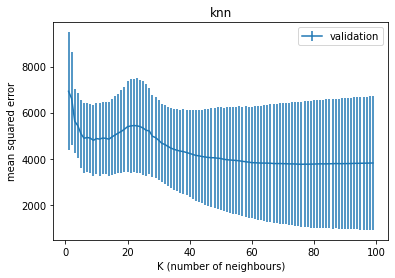

BEST min_samples_leaf for REGION split: 39
Best MSE for REGION split: 4213.88964498416


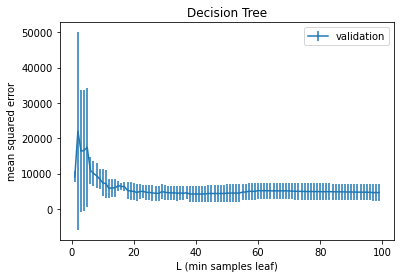

In [434]:
best =  np.argmin(np.mean(errorvalid_knn, axis=1)) + 1

print("BEST K for REGION split:",best)
print("Best MSE for REGION split:",np.mean(errorvalid_knn, axis=1)[best - 1])
#plot the graph
plt.errorbar(K_list, np.mean(errorvalid_knn, axis=1), np.std(errorvalid_knn, axis=1), label='validation')
plt.legend()
plt.title("knn")
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()


best =  np.argmin(np.mean(errorvalid_dt, axis=1)) + 1
print("BEST min_samples_leaf for REGION split:",best)
print("Best MSE for REGION split:",np.mean(errorvalid_dt, axis=1)[best - 1])
#plot the graph
plt.errorbar(K_list, np.mean(errorvalid_dt, axis=1), np.std(errorvalid_dt, axis=1), label='validation')
plt.legend()
plt.title("Decision Tree")
plt.xlabel('L (min samples leaf)')
plt.ylabel('mean squared error')
plt.show()